# This notebook is used to gather the timing information for SD3 model in SMPC setting

## Setting 1: Split 0

In [2]:
import torch
from diffusers import StableDiffusion3Pipeline
import diffusers

# model_id = "stabilityai/stable-diffusion-3-medium-diffusers"
model_id = "/storage/ms5267@drexel.edu/models/stable-diffusion-3-medium-diffusers/models--stabilityai--stable-diffusion-3-medium-diffusers/snapshots/ea42f8cef0f178587cf766dc8129abd379c90671"
pipe = StableDiffusion3Pipeline.from_pretrained(model_id, torch_dtype=torch.float16,text_encoder_3=None)

Loading pipeline components...:   0%|          | 0/8 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [3]:
pipe.to('cuda')


StableDiffusion3Pipeline {
  "_class_name": "StableDiffusion3Pipeline",
  "_diffusers_version": "0.30.0.dev0",
  "_name_or_path": "/storage/ms5267@drexel.edu/models/stable-diffusion-3-medium-diffusers/models--stabilityai--stable-diffusion-3-medium-diffusers/snapshots/ea42f8cef0f178587cf766dc8129abd379c90671",
  "scheduler": [
    "diffusers",
    "FlowMatchEulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "text_encoder_3": [
    null,
    null
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_3": [
    "transformers",
    "T5TokenizerFast"
  ],
  "transformer": [
    "diffusers",
    "SD3Transformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [7]:
# Count the number of parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

# Count parameters for each component
params = {
    "scheduler": 0,
    "text_encoder": count_parameters(pipe.text_encoder),
    "text_encoder_2": count_parameters(pipe.text_encoder_2),
    "tokenizer": 0,  # Tokenizers typically don't have trainable parameters
    "tokenizer_2": 0,
    "tokenizer_3": 0,
    "transformer": count_parameters(pipe.transformer),
    "vae": count_parameters(pipe.vae)
}

# Sum up all parameters
total_params = sum(params.values())

print(f"Total number of parameters: {total_params}")
for component, param_count in params.items():
    print(f"{component}: {param_count}")

Total number of parameters: 2930457827
scheduler: 0
text_encoder: 123650304
text_encoder_2: 694659840
tokenizer: 0
tokenizer_2: 0
tokenizer_3: 0
transformer: 2028328000
vae: 83819683


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

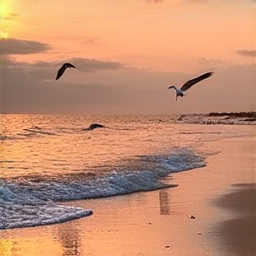

In [10]:
prompts = [
    "Majestic mountains, serene lake, hikers trekking, wildflowers blooming, and birds soaring above.",
    "An oil painting of a medieval King of England wearing a crown and holding a septre standing proud infront of the throne",
    "A futuristic city skyline at night, illuminated by neon lights and flying vehicles.",
    "A cozy, rustic cabin in a snowy forest, with smoke rising from the chimney.",
    "A vibrant underwater scene featuring colorful coral reefs and diverse marine life.",
    "A bustling medieval marketplace filled with vendors, shoppers, and street performers.",
	"An enchanted forest with towering trees, glowing mushrooms, and mystical creatures.",
	"A majestic castle on a hill, overlooking a vast kingdom under a starry sky.",
	"A tranquil beach at sunset, with gentle waves lapping the shore and seagulls flying."
]
img_sizes = [256,512,1024]

repetitions = 1

for size in img_sizes:
	for i in range(0,repetitions):
		for p in prompts:
			image = pipe(
				p,
				num_inference_steps=28,
				guidance_scale=7.0,
				height = size, 
				width = size
			).images[0]
image

In [1]:

import numpy as np
files = ['per_iteration_time_split0_256.txt', 'per_iteration_time_split0_512.txt','per_iteration_time_split0_1024.txt'
		 ,'total_time_split0_256.txt','total_time_split0_512.txt','total_time_split0_1024.txt']

for f in files:
	data = np.loadtxt(f'../../output/{f}')
	mean_time = np.mean(data)
	print(f'{f}:{mean_time}')

per_iteration_time_split0_256.txt:0.03288741196904864
per_iteration_time_split0_512.txt:0.060197455837744315
per_iteration_time_split0_1024.txt:0.2289698388841417
total_time_split0_256.txt:0.9962838225894504
total_time_split0_512.txt:1.8550272625546123
total_time_split0_1024.txt:6.918973022037083


## Setting 2: Split 1

In [1]:


import torch
from diffusers import StableDiffusion3Pipeline
import diffusers


model_id = "stabilityai/stable-diffusion-3-medium-diffusers"
model_id = "/storage/ms5267@drexel.edu/models/stable-diffusion-3-medium-diffusers/models--stabilityai--stable-diffusion-3-medium-diffusers/snapshots/ea42f8cef0f178587cf766dc8129abd379c90671"
pipe = StableDiffusion3Pipeline.from_pretrained(model_id, torch_dtype=torch.float16)

from diffusers.utils.transformer_split_config import TransformerSplitConfig

transformer_split1_host = ['0.0.0.0','0.0.0.0','0.0.0.0']
transformer_split1_port = [1234,2345,3456]

split_config = TransformerSplitConfig(
    num_splits=1,
    hosts=[transformer_split1_host],
    ports=[transformer_split1_port],
    pipe_config=pipe.transformer.config,
    redundant_distributed_servers=True,
    # validation_threshold=0.9
)

client_head = torch.load('../../models/sd3_transformer_client_first.pth')
client_tail = torch.load('../../models/sd3_transformer_client_last.pth')

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [2]:
from diffusers import StableDiffusion3PipelineSplitClientSocket

split_pipe = StableDiffusion3PipelineSplitClientSocket(
    	transformer_client_head_split = client_head,
        transformer_client_tail_split = client_tail,
    	transformer_server_split_config=split_config,
        scheduler = pipe.scheduler,
        vae = pipe.vae,
        text_encoder = pipe.text_encoder,
        tokenizer= pipe.tokenizer,
        text_encoder_2 = pipe.text_encoder_2,
        tokenizer_2=pipe.tokenizer_2,
        text_encoder_3=None,
        tokenizer_3= None)

split_pipe = split_pipe.to("cuda:0")

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

server_model = torch.load('/home/ms5267/blockentropy/models/sd3_transformer_server_1_11.pth')
count_parameters(server_model)


934788096

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

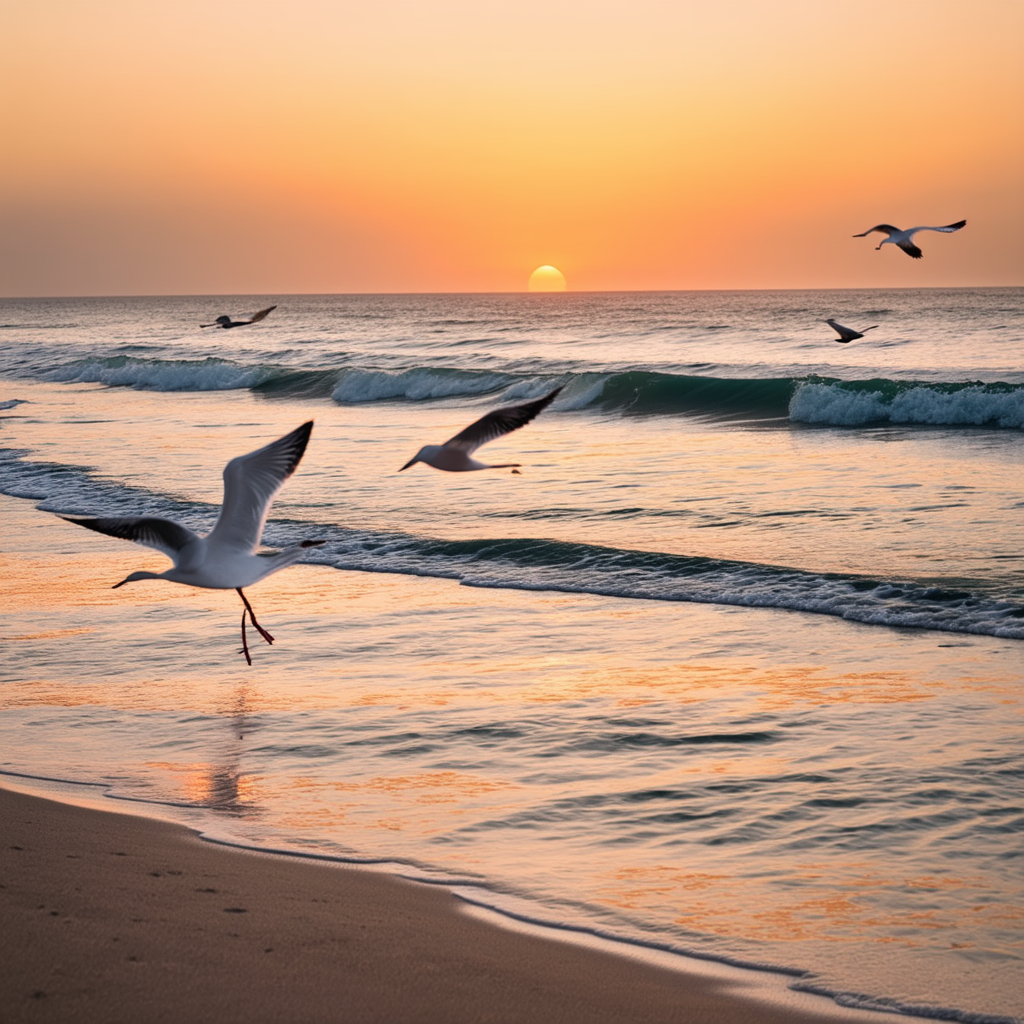

In [6]:
prompts = [
    "Majestic mountains, serene lake, hikers trekking, wildflowers blooming, and birds soaring above.",
    "An oil painting of a medieval King of England wearing a crown and holding a septre standing proud infront of the throne",
    "A futuristic city skyline at night, illuminated by neon lights and flying vehicles.",
    "A cozy, rustic cabin in a snowy forest, with smoke rising from the chimney.",
    "A vibrant underwater scene featuring colorful coral reefs and diverse marine life.",
    "A bustling medieval marketplace filled with vendors, shoppers, and street performers.",
	"An enchanted forest with towering trees, glowing mushrooms, and mystical creatures.",
	"A majestic castle on a hill, overlooking a vast kingdom under a starry sky.",
	"A tranquil beach at sunset, with gentle waves lapping the shore and seagulls flying."
]
img_size = [256,512,1024]
repetitions = 1

for size in img_size:
	for i in range(0,repetitions):
		for p in prompts:
			image = split_pipe(
				p,
				num_inference_steps=28,
				guidance_scale=7.0,
				height = size, 
				width = size
			).images[0]
image

In [4]:
import numpy as np
files = ['per_iteration_time_split1_256.txt', 'per_iteration_time_split1_512.txt','per_iteration_time_split1_1024.txt'
		 ,'total_time_split1_256.txt','total_time_split1_512.txt','total_time_split1_1024.txt'
		 ,'verification_time_split1_256.txt','verification_time_split1_512.txt','verification_time_split1_1024.txt'
		 ]

for f in files:
	data = np.loadtxt(f'../../output/{f}')
	mean_time = np.mean(data)
	print(f'{f}:{mean_time}')

per_iteration_time_split1_256.txt:0.1612921962324454
per_iteration_time_split1_512.txt:0.25657608159004697
per_iteration_time_split1_1024.txt:1.0241126947932773
total_time_split1_256.txt:4.663518360682896
total_time_split1_512.txt:7.337736368179321
total_time_split1_1024.txt:29.022139774428474
verification_time_split1_256.txt:0.9162545033863613
verification_time_split1_512.txt:1.0905986626942952
verification_time_split1_1024.txt:4.987745695643955


  0%|          | 0/1 [00:00<?, ?it/s]

sent_data_size: 26119155
sent_data_size: 26119155
sent_data_size: 26119155
received_data_size: 26119158
****************
received_data_size: 26119158
****************
received_data_size: 26119158
****************


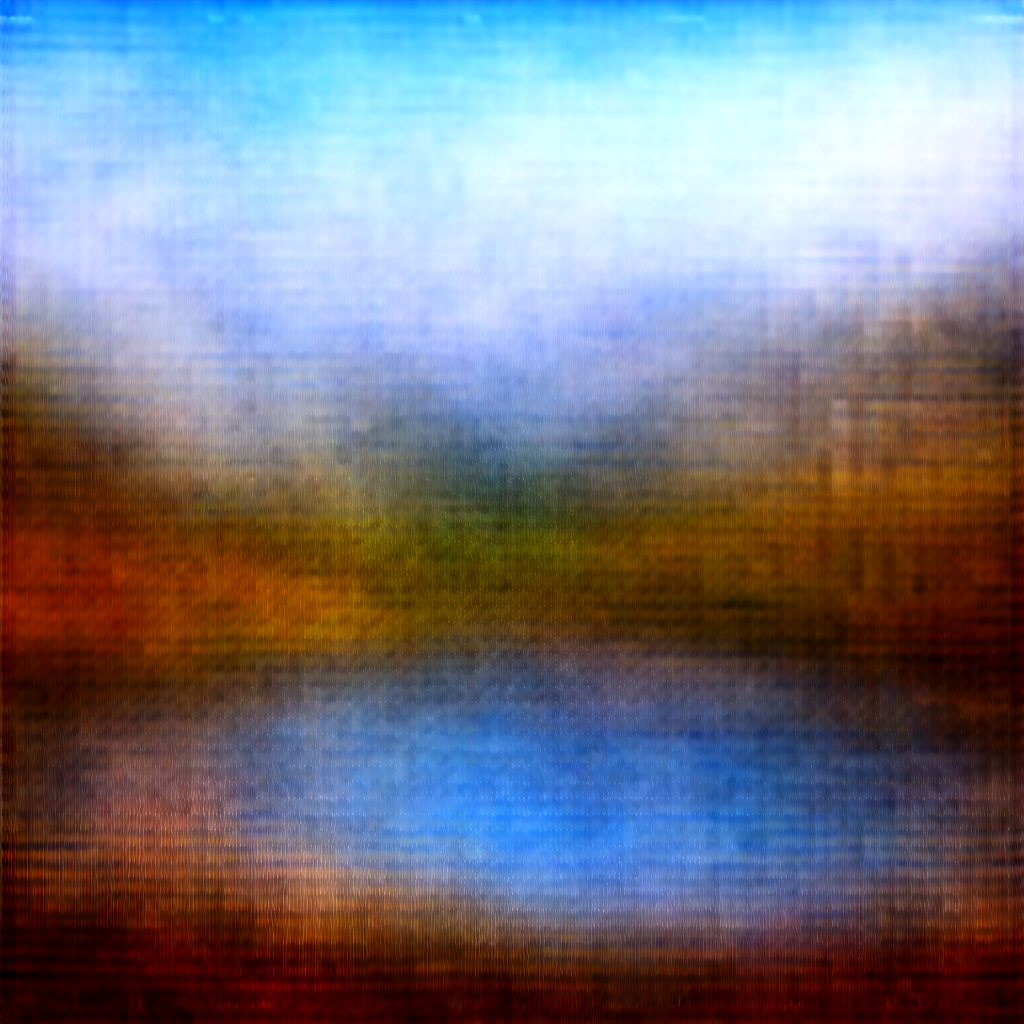

In [10]:

image = split_pipe(
	"Majestic mountains, serene lake, hikers trekking, wildflowers blooming, and birds soaring above.",
	num_inference_steps=1,
	guidance_scale=7.0,
	height = 1024, 
	width = 1024
).images[0]

image


In [11]:
(26119155+26119158)/1024/1024

49.81833744049072

## Setting 3: Split 2

In [1]:


import torch
from diffusers import StableDiffusion3Pipeline
import diffusers


model_id = "stabilityai/stable-diffusion-3-medium-diffusers"
model_id = "/storage/ms5267@drexel.edu/models/stable-diffusion-3-medium-diffusers/models--stabilityai--stable-diffusion-3-medium-diffusers/snapshots/ea42f8cef0f178587cf766dc8129abd379c90671"
pipe = StableDiffusion3Pipeline.from_pretrained(model_id, torch_dtype=torch.float16)

from diffusers.utils.transformer_split_config import TransformerSplitConfig

transformer_split1_host = ['0.0.0.0','0.0.0.0','0.0.0.0']
transformer_split1_port = [1234,2345,3456]

transformer_split2_host = ['0.0.0.0','0.0.0.0','0.0.0.0']
transformer_split2_port = [9876,8765,7654]

split_config = TransformerSplitConfig(
    num_splits=2,
    hosts=[transformer_split1_host,transformer_split2_host],
    ports=[transformer_split1_port,transformer_split2_port],
    pipe_config=pipe.transformer.config,
    redundant_distributed_servers=True,
    validation_threshold=0.9
)

client_head = torch.load('../../models/sd3_transformer_client_first.pth')
client_tail = torch.load('../../models/sd3_transformer_client_last.pth')

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
from diffusers import StableDiffusion3PipelineSplitClientSocket

split_pipe = StableDiffusion3PipelineSplitClientSocket(
    	transformer_client_head_split = client_head,
        transformer_client_tail_split = client_tail,
    	transformer_server_split_config=split_config,
        scheduler = pipe.scheduler,
        vae = pipe.vae,
        text_encoder = pipe.text_encoder,
        tokenizer= pipe.tokenizer,
        text_encoder_2 = pipe.text_encoder_2,
        tokenizer_2=pipe.tokenizer_2,
        text_encoder_3=None,
        tokenizer_3= None)

split_pipe = split_pipe.to("cuda:0")

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

server_model = torch.load('/home/ms5267/blockentropy/models/sd3_transformer_server_1_11.pth')
count_parameters(server_model)


934788096

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

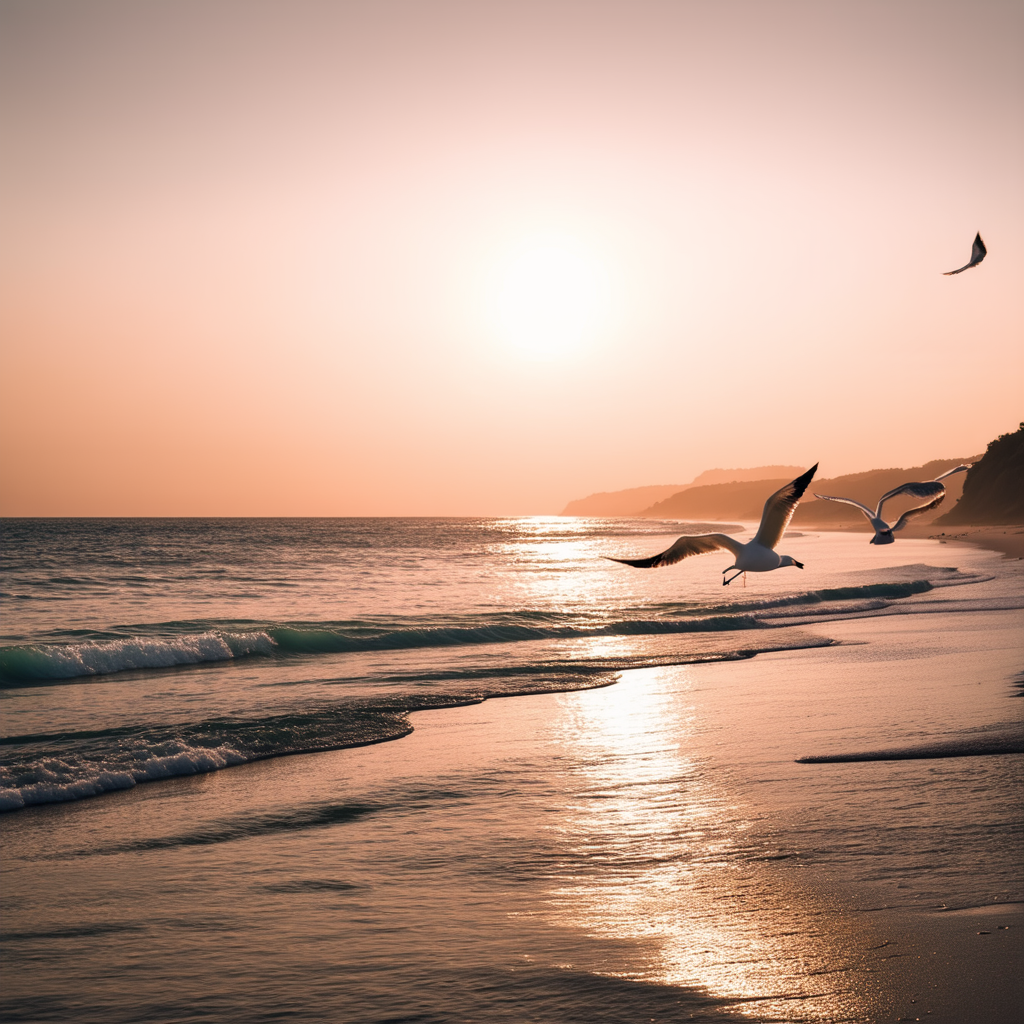

In [4]:
prompts = [
    "Majestic mountains, serene lake, hikers trekking, wildflowers blooming, and birds soaring above.",
    "An oil painting of a medieval King of England wearing a crown and holding a septre standing proud infront of the throne",
    "A futuristic city skyline at night, illuminated by neon lights and flying vehicles.",
    "A cozy, rustic cabin in a snowy forest, with smoke rising from the chimney.",
    "A vibrant underwater scene featuring colorful coral reefs and diverse marine life.",
    "A bustling medieval marketplace filled with vendors, shoppers, and street performers.",
	"An enchanted forest with towering trees, glowing mushrooms, and mystical creatures.",
	"A majestic castle on a hill, overlooking a vast kingdom under a starry sky.",
	"A tranquil beach at sunset, with gentle waves lapping the shore and seagulls flying."
]
img_size = [256,512,1024]
repetitions = 1

for size in img_size:
	for i in range(0,repetitions):
		for p in prompts:
			image = split_pipe(
				p,
				num_inference_steps=28,
				guidance_scale=7.0,
				height = size, 
				width = size
			).images[0]
image

In [5]:
import numpy as np
files = ['per_iteration_time_split2_256.txt', 'per_iteration_time_split2_512.txt','per_iteration_time_split2_1024.txt'
		 ,'total_time_split2_256.txt','total_time_split2_512.txt','total_time_split2_1024.txt'
		 ,'verification_time_split2_256.txt','verification_time_split2_512.txt','verification_time_split2_1024.txt'
		 ]

for f in files:
	data = np.loadtxt(f'../../output/{f}')
	mean_time = np.mean(data)
	print(f'{f}:{mean_time}')

per_iteration_time_split2_256.txt:0.26255676292237784
per_iteration_time_split2_512.txt:0.46409061882230973
per_iteration_time_split2_1024.txt:1.77299997447029
total_time_split2_256.txt:7.518838299645318
total_time_split2_512.txt:13.148869037628174
total_time_split2_1024.txt:49.989172564612495
verification_time_split2_256.txt:1.7844843334621854
verification_time_split2_512.txt:2.2053667969173856
verification_time_split2_1024.txt:9.49266168806288
